### Jash Gandhi
### BE IT
### 2018140019
#### Implementation of Image Enhancement using Genetic Algorithm

#### Constants defined

pop_size -> population size of algorithm (50)


Gray level -> assumed total 255

Number of parents selected for mating -> 4

Crossover rate -> 0.3

Mutation rate -> 0.1

Crossover type -> Two point crossover

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import sys
from random import randint
from numpy.random import default_rng
import random
# import time
from tqdm.notebook import tqdm_notebook
rng = default_rng()
np.random.seed(909)


### Constants Defined

In [11]:
pop_size = 200
num_parents = 4

crossover_rate = 0.3
num_individuals = pop_size

total_offsprings_in_each_gen = int(crossover_rate * num_individuals)

mutation_rate = 0.1

crossover_type = 'two-point-crossover'

### Genetic Algorithm functions

#### Creating Initial Population

In [5]:
def create_population(N,size):
    arr = []
    for _ in range(size):
        tp = [randint(1,244) for _ in range(N-2)]
        tp.extend([0,255])
        # 0 and 255 are added according to the paper
        tp.sort()
        arr.append(tp)
    return np.array(arr)

#### Fitness Function and Image generation from old and new gray levels

As mentioned in the paper,the fitness function used is

Fitness function = sum of intensities of the image x edges count



In [6]:
def create_enhanced_image(original_gray_levels,enhanced_gray_levels,img_array):
    assert(len(original_gray_levels)==len(enhanced_gray_levels)) 
    hmap={}
    for i in range(len(enhanced_gray_levels)):
        hmap[original_gray_levels[i]]=enhanced_gray_levels[i]
    # iterate through each pixel and change it to enhanced one as mentioned in paper for edge detection
    enhanced_image=np.empty(img_array.shape)
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            enhanced_image[i][j]=hmap[img_array[i][j]]
            
    return enhanced_image

def count_edges(img_array):
    edges = cv2.Canny(np.uint8(img_array), threshold1=100, threshold2=200)
    edge_count = np.count_nonzero(edges)
    return edge_count

def fitness_function(population):
    fitness=[]
    for chromosome in population:
        fitness.append(fitness_func_for_one(chromosome))
    return np.array(fitness)
    
def fitness_func_for_one(chromosome):
    global gray_levels,img_array
    enhanced_img_array = create_enhanced_image(gray_levels,chromosome,img_array)
    edge_count = count_edges(enhanced_img_array)
    
#     global freq
#     intensities = sum([chromosome[i]*freq[i] for i in range(len(chromosome))])
#     return np.log(np.log(intensities)) * edge_count
    return edge_count

#### Selection

Roulette wheel selection is used in the paper


Two methods are implemented below

In [7]:
def generate_mating_pool(population,total_offsprings_in_each_gen,fitness):
    parents = np.empty((total_offsprings_in_each_gen, population.shape[1]))
    for parent_num in range(total_offsprings_in_each_gen):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999 # so that it doesnt get selected the next time
        
    return parents

def roulette_wheel_selection(population,fitness,total_offsprings_in_each_gen):
  # Computes the totallity of the population fitness
    population_fitness = sum(fitness)
    
    # Computes for each chromosome the probability 
    chromosome_probabilities = [fitness[i]/population_fitness for i,chromosome in enumerate(population)]
    
    parents = rng.choice(population,p=chromosome_probabilities,size=total_offsprings_in_each_gen,replace=False)
    
    return parents

#### Crossover

Two point and one point crossover are implemented

Paper suggests the use of two point crossover


In [8]:
def randomNumGen(limit,count):
    return np.sort(rng.choice(np.arange(limit[0],limit[1]+1),size=count,replace=False))
        

def crossover(c_type,parents,offspring_size,population):
    '''
    performing crossover between 2 parents
    parameters:
    c_type: crossover type
    parents: the parents used to create offspring
    offspring size: tuple of (genes in a chromosome,number of offsprings to be created)
    population,
    '''
    
    assert c_type=="two-point-crossover" or c_type=='single-point-crossover',"Crossover types supported are two point and one point"
    
    if c_type=="two-point-crossover":
        return two_point_crossover(parents,offspring_size,population)
    else:
        return one_point_crossover(parents,offspring_size,population)

def two_point_crossover(parents,offspring_size,population):
    
    for k in range(offspring_size[1]):
        c_point = randomNumGen((0,offspring_size[0]),2)
        parent1_idx = (2*k)%parents.shape[0]
        parent2_idx = (2*k+1)%parents.shape[0]
        
        offspring1 = np.concatenate((parents[parent1_idx][:c_point[0]],parents[parent2_idx][c_point[0]:c_point[1]],parents[parent1_idx][c_point[1]:]))
        assert(len(offspring1)==len(parents[k]))
        
        offspring2 = np.concatenate((parents[parent2_idx][:c_point[0]],parents[parent1_idx][c_point[0]:c_point[1]],parents[parent2_idx][c_point[1]:]))
        assert(len(offspring2)==len(parents[k]))
        
        offsprings = [offspring1,offspring2]
        parent_idxs = [parent1_idx,parent2_idx]
        population = replace_parents_with_offsprings(population,offsprings,parent_idxs,parents)
        
        
    return population

def one_point_crossover(parents,offspring_size,population):
    
    for k in range(offspring_size[1]):
        c_point = randomNumGen((0,offspring_size[0]),1)
        parent1_idx = (2*k)%parents.shape[0]
        parent2_idx = (2*k+1)%parents.shape[0]
        
        offspring1 = np.concatenate((parents[parent1_idx][:c_point[0]],parents[parent2_idx][c_point[0]:]))
        assert(len(offspring1)==len(parents[k]))
        
        offspring2 = np.concatenate((parents[parent2_idx][:c_point[0]],parents[parent1_idx][c_point[0]:]))
        assert(len(offspring2)==len(parents[k]))
        
        offsprings = [offspring1,offspring2]
        parent_idxs = [parent1_idx,parent2_idx]
        population = replace_parents_with_offsprings(population,offsprings,parent_idxs,parents)
                                    
    return population

def replace_parents_with_offsprings(population,offsprings,parent_idxs,parents):
    for idx in parent_idxs:
        curr_offspring = offsprings.pop(0)
        # after crossover, they may not be sorted
        curr_offspring.sort()
        curr_offspring = np.reshape(curr_offspring,(1,-1))
        ind = np.where((population==parents[idx]).all(-1))[0]
        population[ind] = curr_offspring
    return population
    

#### Mutation

In [9]:
def mutation(mutation_rate,population):
    
    '''
    adding mutation in the current population
    randomly setting 5% of the genes of the selected chromosomes from the population
    
    the value is set randomly between the previous and next gene value(gray levels)
    '''
    
    no_of_genes = len(population[0])
    for pop_ind,chromosome in enumerate(population):
        if np.random.random()<mutation_rate:
            #do mutation
            #5% of genes are to be mutated as mentioned in the paper
            count = int(0.05*no_of_genes)
            selected_to_be_mutated =  np.sort(rng.choice(np.arange(1,no_of_genes-1),size=count,replace=False))
            # the index range is set between 1 and n-1 so that initial and final dynamic range(0,255) are not changed
            
            for index in selected_to_be_mutated:
                chromosome[index] = np.int64(random.randint(chromosome[index-1].item(),chromosome[index+1].item()))
                # a random number between previous and next is added
                
            #after mutation, the chromosome is replaced with the original one in the population
            population[pop_ind] = chromosome
            
    return population
                
        

#### Load Image and pre processing 

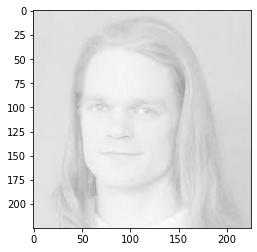

In [12]:
img = Image.open('kaka.jfif').convert('L')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [13]:
img_array = np.asarray(img)
print("IMAGE SHAPE:",img_array.shape)
gray_levels,freq = np.unique(img_array,return_counts=True)
# gray_levels = np.reshape(gray_levels,(1,-1))
gray_levels.sort()
print("GRAY LEVEL SHAPE:",gray_levels.shape)
N = len(gray_levels)
print(N)

IMAGE SHAPE: (225, 225)
GRAY LEVEL SHAPE: (97,)
97


Hence, the length of one chromosome for this particular image will be 125 i.e. 125 genes in a chromosome

Different images will have different length of a chromosome

#### Creating the initial population

In [14]:
# initializing the population with array of 125 elements

# creating population of 50 chromosomes
population = create_population(N,pop_size)
print(population.shape)
print("For sample: ",population[0])

(200, 97)
For sample:  [  0   1   4   4   9  18  19  22  22  25  26  29  32  36  38  39  46  47
  54  56  57  60  61  61  62  64  64  64  67  68  68  75  75  77  77  82
  83  97  97  97 100 102 102 104 105 108 109 111 112 115 115 118 119 120
 121 122 127 132 133 135 142 145 145 148 155 156 161 165 166 166 168 176
 190 195 200 202 202 203 207 208 209 209 211 216 218 219 223 227 228 228
 231 231 233 235 240 244 255]


In [11]:
# for chromosome in population:
#     check_sorted(chromosome)

#### Displaying an image from the initialized population

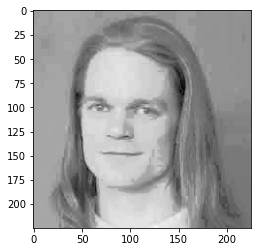

In [15]:
# JUST FOR CHECKING

checking_img = create_enhanced_image(gray_levels,population[0],img_array)
plt.imshow(checking_img, cmap='gray', vmin=0, vmax=255)
# print("Image")

#### Main loop for Genetic Algorithm

In [16]:
new_pop = population
num_generations = 100
for gen in tqdm_notebook(range(num_generations)):
    
    
    fitness = fitness_function(new_pop)
    parents = roulette_wheel_selection(new_pop,fitness,total_offsprings_in_each_gen)
#     print("SELECTED PARENTS SHAPE:",parents.shape)
#     print(population.shape)
    new_pop = crossover(crossover_type,parents,(N,total_offsprings_in_each_gen),new_pop)
    
    new_pop  = mutation(mutation_rate,new_pop)
    
    if (gen+1)%10==0:
        fitness = fitness_function(new_pop)
        print(f"at {gen+1}th generation, population's best is  {max(fitness)}")

  0%|          | 0/100 [00:00<?, ?it/s]

at 10th generation, population's best is  3603
at 20th generation, population's best is  3860
at 30th generation, population's best is  3858
at 40th generation, population's best is  3849
at 50th generation, population's best is  3887
at 60th generation, population's best is  3748
at 70th generation, population's best is  3726
at 80th generation, population's best is  3707
at 90th generation, population's best is  3517
at 100th generation, population's best is  3538


#### Picking the most fit solution after applying Genetic Algorithm

In [17]:
fitness = fitness_function(new_pop)
max_ind = np.where(fitness==max(fitness))
# print(max_ind)
# max_ind = np.where(fitness==max(fitness))
best_contrasted_img_array = new_pop[max_ind]

In [18]:
best_contrasted_img_array.shape,gray_levels.shape

((1, 97), (97,))

In [19]:
best_contrasted_img_array = np.reshape(best_contrasted_img_array,gray_levels.shape)
best_contrasted_img = create_enhanced_image(gray_levels,best_contrasted_img_array,img_array)

#### Traditional method of Histogram Equalization

In [20]:
def equalizeHistogram(img_array):
    gray_levels,freq = np.unique(img_array,return_counts=True)
    N = len(gray_levels)
    histogram=enumerate(freq)
    nk=[]
    pdf=[]
    cdf=[]
    final_grey_levels=[]
    tp_cdf=0
    total = sum(freq)
    for i in range(N):
        nk.append(freq[i])
        pdf.append(freq[i]/total)
        cdf.append(tp_cdf+pdf[i])
        tp_cdf=cdf[i]
        final_grey_levels.append(round((N-1)*cdf[i]))
    return create_enhanced_image(gray_levels,final_grey_levels,img_array)

#### Displaying all images for visualization purposes

Text(0.5, 1.0, 'Histogram Equalized Image')

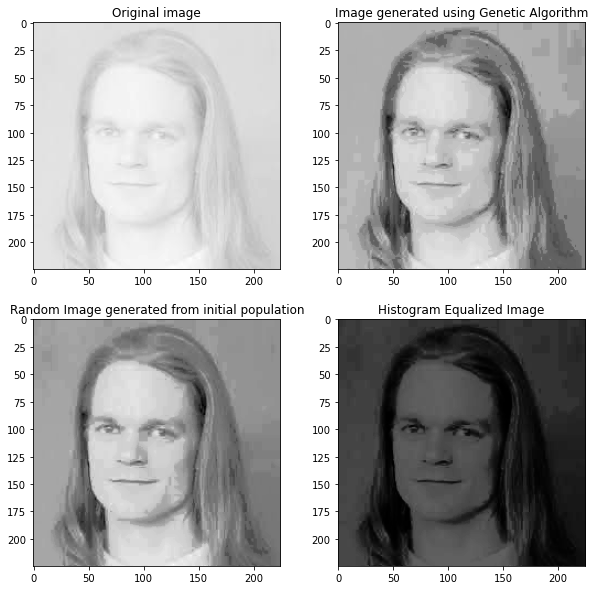

In [21]:
f, axarr = plt.subplots(2,2,figsize=(10,10))

axarr[0,0].imshow(img, cmap='gray', vmin=0, vmax=255)
axarr[0,0].set_title("Original image")

axarr[0,1].imshow(best_contrasted_img, cmap='gray', vmin=0, vmax=255)
axarr[0,1].set_title("Image generated using Genetic Algorithm")

axarr[1,0].imshow(checking_img, cmap='gray', vmin=0, vmax=255)
axarr[1,0].set_title("Random Image generated from initial population")

equalized = equalizeHistogram(img_array)
axarr[1,1].imshow(equalized,cmap='gray',vmin=0,vmax=255)
axarr[1,1].set_title("Histogram Equalized Image")

#### Edge count between image enhanced by GA and HE

In [22]:
print(count_edges(best_contrasted_img),count_edges(equalized))

3538 1170


In [23]:
print(count_edges(best_contrasted_img),count_edges(cv2.equalizeHist(img_array)))

3538 4122


### References:

1. Research Paper: https://ieeexplore.ieee.org/abstract/document/5190563

2. Genetic Algorithm: https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6 